# Baysian Logistic Regression with MCMC (Metropolis Sampling)

In this notebook, I will implement MCMC (more specifically, Metropolis sampling) approach to Bayesian logistic regression from scratch. 

In [1]:
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt

# 1 Setting

In this notebook, we consider binary classification problem for simplicity.
Multiclass classification cases may be treated in almost the same way (Although I have not tried.).

Let us define some symbols as follows:
* $N \in \mathbb{N}$ : data size
* $d \in \mathbb{N}$ : the dimension of the features. 
* Denote input data by $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^d$. 
* Denote label data by $y_0, y_1, \dots, y_{N-1} \in \{ 0, 1 \}$.

Also, we collectively denote $x_0, x_1, \dots , x_{N-1}$ by $X$, and $y_0, y_1, \dots, y_{N-1}$ by $Y$, respectively.

# 2 Model 

We assume the following probabilistic model:
$$
\begin{align}
    p(Y | X, w) &= \prod_{n=0}^{N-1} \sigma(w \cdot \phi(x_n))^{y_n} [1 - \sigma(w \cdot \phi(x_n))]^{1-y_n} \\
    \sigma(a) &:= \frac{1}{1 + e^{-a}} \mbox{  (sigmoid function)}\\
    p(w | \alpha) &= \left( \frac{\alpha}{2 \pi} \right)^{M/2} \exp\left( - \frac{\alpha}{2} \| w \|^2  \right) 
        \mbox{   (prior, Normal distribution)}\\
    p(\alpha | k, \lambda) &= \begin{cases}
        \frac{\lambda}{\Gamma(k)} \alpha^{k-1} e^{-\lambda \alpha}  & (\alpha > 0)\\
        0 & (\alpha \leq 0)
       \end{cases} \mbox{  (hyper prior, Gamma distribution)}
\end{align}
$$
where
* $\phi : \mathbb{R}^d \rightarrow \mathbb{R}^M $, $\phi(x) = (\phi_0(x), \dots, \phi_{M-1}(x))^T$ are basis functions, with $M \in \mathbb{R}$, 
* $w \in \mathbb{R}^M$ is the weight parameter,
* $\alpha > 0$ is the precision of the prior.

Later, we use "linear" basis function
$$
\begin{align}
    \phi_j(x) = \begin{cases}
        1 & (j=0)\\
        x^{(j-1)} & (j = 1.\dots, d) 
    \end{cases}
\end{align},
$$
where $x^{(j)}$ represents $j$-th element of $x \in \mathbb{R}^d$


The posterior distribution of $w$ and $\alpha$ can be written as 
$$
\begin{align}
    p(w, \alpha | X, Y) &= \frac{p(Y | X, w) p(w|\alpha) p(\alpha)}{p(Y | X)} \\
    &\propto \tilde{p}(w, \alpha) 
\end{align} 
$$
where $\tilde{p}$ is defined by
$$
\begin{align}
    \tilde{p}(w, \alpha) = 
    \begin{cases}
        \prod_{n=0}^{N-1} \sigma(w \cdot \phi(x_n))^{y_n} [1 - \sigma(w \cdot \phi(x_n))]^{1-y_n} 
        \times \alpha^{M/2 + k - 1} \exp\left( - \frac{\alpha}{2} \| w \|^2  - \lambda \alpha \right) & ( \alpha > 0) \\
        0 & (\alpha \leq 0)
    \end{cases}
\end{align}
$$
Here we ommitted factors that do not depend on $w, \alpha$.

To perform Bayesian inference, we would like to draw samples of $(w, \alpha)$ from this posterior distribution.

# 3 Metropolis sampling

Here, we shall use Metropolis sampling to sample from the posterior distribution.
Let us first describe Metropolis sampling in general, leaving the logistic regression problem for a while.

Here I just give a rough sketch, and those who are interested in the rationale and background, please refer to literature, for example, Chapter 11 of Bishop "Pattern Recognition and Machine Learning".

## 3.1 Notation

Let us define notations as follows: 
* $\Theta$ : a set (or more precisely, a measurable space with an appropriate sigma algebra, but we do not care about such detail here), on which we consider probability distribution 
* $p(\theta) = \tilde{p}(\theta)/Z_p$ : the density function of the distribution from which we want to sample, where the constant $Z_p$ can be unknown.
* $q(\theta| \theta')$ : proporsal kernel, where $q(\theta|\theta')$ stands for the probability density of getting $\theta$ as a candidate, provided that we have $\theta'$ now. For simplicity, we assume that $q$ is symmetric, i.e., $q(\theta|\theta') = q(\theta'|\theta)$ for any $\theta, \theta' \in \Theta$.

## 3.2 Algorithm

* input : the initial point $\theta^{ini} \in \Theta$, the number of samples required $N$
* output : the sequence of variables $\theta^{(0)}, \theta^{(1)}, \dots \theta^{(N-1)}$, which (approximately) obey the distribution $p$.
* Given $\theta^{current}$, generate $\theta^{tmp}$ according to $q(\cdot | \theta^{current})$. 
* Set the next state $\theta^{next}$ as 

$$
\begin{align}
    \theta^{next} = 
    \begin{cases}
        \theta^{tmp} & (\mbox{with probability } A(\theta^{tmp}, \theta^{current})) \\ 
        \theta^{current} & (\mbox{with probability } 1 - A(\theta^{tmp}, \theta^{current}))
    \end{cases},
\end{align}
$$

where

$$
\begin{align}
    A(\theta,\theta') := \min\left( 1, \ \frac{\tilde{p}(\theta)}{\tilde{p}(\theta')} \right)
\end{align}
$$

We record points only once in a several steps to obtain more "independent" samples, 
because it is expected that adjacent points in this sequence are highly correlated with each other.


## 3.3 Implementation

As the proposal kernel, we shall use a normal distribution.

The implementation of the algorithm described above is almost straightforward, but there will be a modification to avoid numerical accuracy problem: instead of calculating the ratio of $\tilde{p}$ directly, we shall calculate $\log \tilde{p}$.
This is because, in our application, $\tilde{p}$ contains product over samples, thereby giving exponentially small value with respect to sample size, which could cause underflow.

In [2]:
class MetropolisSampler:
    def __init__(self, dim, sigma, logp):
        self.dim = dim # the dimension of the output space       
        self.sigma = sigma # the covariance matrix of the proporsal kernel
        self.logp = logp # the log of the (unnormalized) density function of the target distribution
    
    def _A(self, x, y):
        '''
        The method which returns the acceptance probability, 
        depending on the current state y and the candidate state x
        
        Parameters
        ----------
        x : 1D numpy array
            1D numpy array representing the candidate state
        y : 1D numpy array
            1D numpy array representing the current state
        Returns 
        ----------
        A : float
            The acceptance probability A(x, y), 
            where y is the current state, and x is the candidate state.
        '''
        diff_logp = self.logp(x) - self.logp(y)
        if np.isnan(diff_logp):
            raise Exception("Error: the difference of logp returned nan.")
        else:
            return min( 1.0, np.exp(diff_logp) )
    
    def sample(self, xini, n_sample, stride, verbose=False):
        '''
        The method that performs sampling using Metropolis algorithm, and returns the samples
        
        Parameters
        ----------
        xini : 1D numpy array
            1D numpy array representing the initial point
        n_sample : int
            An integer representing the number of samples required.
        stride : int
            An integer representing how frequent samples are recorded.
            More specifically, we only record sample once in `stride` steps
            
        Returns 
        ----------
        X : 2D array
            (N, self.dim) array representing the obtained samples, where X[n] is the n-th sample.
        '''
        X = np.zeros((n_sample, self.dim))  # array for recording the sample
        x = xini
        cnt = 0
        for i in range((n_sample-1) * stride + 1):
            xtmp = np.random.multivariate_normal(x, self.sigma)  # sample from the proporsal kernel (gaussian )
            tmprand = random.random()
            Aval = self._A(xtmp, x)
            if tmprand < Aval:
                x = xtmp
            if i % stride == 0:
                X[cnt] = x
                cnt += 1
            if verbose:
                print(f"candidate point : {xtmp}")
                print(f"threshold : {Aval}")
                print("accepted" if tmprand < Aval else "rejected")
                if i % stride == 0: print("point recorded")
                print("-----------")
            
        return X

# 4 Bayesian Logistic Regression

Having implemented `MetropolisSampler`, we return to the Bayesian logistic regression problem.

## 4.1 Training
For our logistic regression setting, the log of the (uunnormalized) probability density function is given by
$$
\begin{align}
    \log \tilde{p}(w, \alpha) 
       = \sum_{n: y_n=1} \log \sigma(w \cdot \phi(x_n)) + \sum_{n : y_n=0}\log [1 - \sigma(w \cdot \phi(x_n))] 
        {} + \left( \frac{M}{2} + k - 1 \right) \log \alpha 
        {} - \left( \lambda + \frac{1}{2} \| w \|^2 \right)\alpha
\end{align}
$$
for $\alpha > 0$ (and $-\infty$ for $\alpha \leq 0$).

In implementing the funciton, cares should be taken to prevent $\log \sigma(a)$ and $\log (1 - \sigma(a))$ from giving rise to negative infinity due to finite numerical precision. To do so, we shall clip these values by `ndarray.clip` method.

The sampled parameters are stored for later prediction phase.


## 4.2 Prediction

Let us denote the input for which we want to make prediciton by $\Xi = (\xi_0, \dots, \xi_{\nu-1})$, with $\nu \in \mathbb{N}$ being the input data size.

In prediction phase, we first calculate $w \cdot \phi(\xi_n)$, which we call activation.
By examining the distribution of activation, we can gain insight on the uncertainty of the prediciton. This point will be exemplified with simple examples later.

In [3]:
class BayesianLogisticRegressionMCMC:
    
    def __init__(self, k=1.0, lamda=1.0):
        self.k = k # the parameter for hyperprior (Gamma distribution)
        self.lamda = lamda # the parameter for hyperprior (Gamma distribution)
        
    def fit(self, X, y, n_mc_sample=100, mc_stride=10, theta0=None, verbose=False):
        '''
        The method perform fitting (sampling and storing parameters by MCMC from posterior distribution).
        
        Parameters
        ----------
        X : 2-D numpy array
            Array representing training input data, with X[n, i] being the i-th element of n-th point in X.
        y : 1-D numpy array
            Array representing training label data. Each component should be either 0 or 1
        n_mc_sample : positive int
            The number of MCMC samples recorded.
        mc_stride : positive int
            (Inverse) frequency of recording samples in MCMC, 
            i.e., the samples are recorded only once in mc_stride steps. 
        theta0 : 1-D numpy array, default None
            Inintial value of parameters for MCMC.
            The length should be X.shape[1] + 2
            If it is not given, then random values will be used.
        verbose: boolean, default False
            Whether to show the detailed progress of MCMC.
        '''
        N, d = X.shape
        M = d + 1
        Phi = np.c_[np.ones((N, 1)), X]
        
        def logp(theta):
            # we regard theta[0] as alpha, and the remaining elements as w
            alpha = theta[0]
            w = theta[1:]
            if alpha <= 0: 
                return -float("inf")
            sigma = 1/(1 + np.exp(- Phi @ w))
            # clipping the value to avoid negative infinity coming from log sigmoid parts
            arg_positive = sigma[np.where(y==1)].clip(min=1e-12, max=None)
            arg_negative = (1 - sigma[np.where(y==0)]).clip(min=1e-12, max=None)
            return np.sum(np.log(arg_positive)) + np.sum(np.log(arg_negative)) + (M/2 + self.k - 1)*np.log(alpha) - (self.lamda + 0.5*np.linalg.norm(w)**2)*alpha
        
        sampler = MetropolisSampler(dim=M+1, sigma=np.eye(M+1), logp=logp)
        thetaini = theta0 if theta0 is not None else np.random.random(size=M+1)
        self.param_samples_ = sampler.sample(xini=thetaini, n_sample=n_mc_sample, stride=mc_stride, verbose=verbose)
            
    def predict_activation_sample(self, X):
        '''
        The method returning the samples of activation, with respect to posterior distribution samples obtained by MCMC.
        
        Parameters
        ----------
        X : 2-D numpy array
            Array representing test input data, with X[n, i] being the i-th element of n-th point in X.
        Returns
        ----------
        act : 2-D numpy array
            (X.shape[0], n_mc_sample) array, 
            where act[n, k] represents the value of $w \cdot \phi(x_n)$ for the k-th parameter in the MCMC samples
        '''
        N, d = X.shape
        M = d + 1
        Phi = np.c_[np.ones((N, 1)), X]
        W = self.param_samples_[:, 1:]
        return Phi @ (W.T)
    
    def predict_proba(self, X):
        '''
        The method returning the mean
        of the probability that the label is positive, for each input.
        
        Parameters
        ----------
        X : 2-D numpy array
            Array representing test input data, with X[n, i] being the i-th element of n-th point in X.
        Returns
        ----------
        p : 1-D numpy array
            (X.shape[0], ) array, where p_mean[n] represents 
            the expected probability that input X[n]'s label is positive
        '''
        act_sample = self.predict_activation_sample(X)
        p_sample = 1/(1 + np.exp(-act_sample))
        return p_sample.mean(axis=1)
    
    def predict(self, X):
        '''
        The method returning the predicted label for each input.
        
        Parameters
        ----------
        X : 2-D numpy array
            Array representing test input data, with X[n, i] being the i-th element of n-th point in X.
        
        Returns
        ----------
        label : 1-D numpy array
            (X.shape[0], ) array, where label[n] represents 
            the predicted label for X[n]
        '''
        return (self.predict_proba(X) >= 0.5).astype(np.int)


# 5 Experiment : toy data


Let us first apply our classifier to toy data, and examine its behavior. 
For illustration, we shall use the following two dimensional toy data.

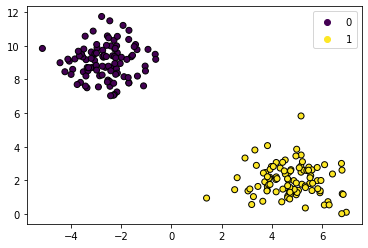

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=200, n_features=2, centers=2, random_state=42)
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

In [5]:
blr = BayesianLogisticRegressionMCMC()
blr.fit(X=X, y=y, n_mc_sample=1000, mc_stride=20, verbose=False)

Let's take a look at distribution of each parameter.

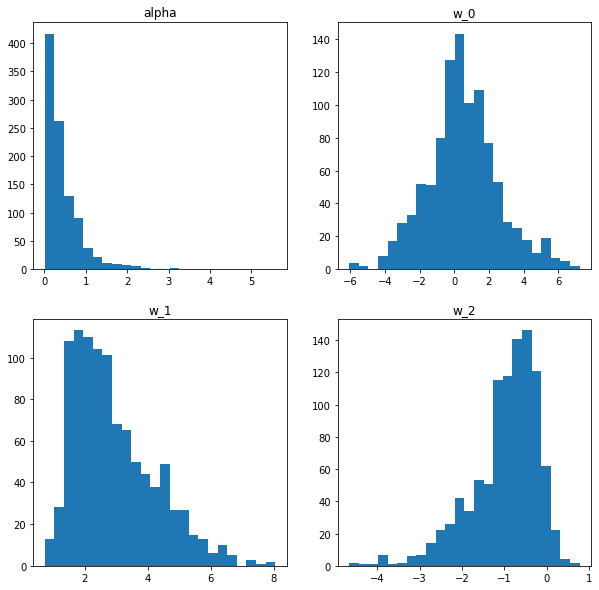

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
param_names = ['alpha', 'w_0', 'w_1', 'w_2']
num_steps = 25

for idx, (ax, param_name) in enumerate(zip(np.ravel(axes), param_names)):
    sample = blr.param_samples_[:,idx]
    ax.hist(sample, bins=np.linspace(sample.min(), sample.max(), num_steps), density=False)
    ax.set_title(param_name)
plt.show()

We can see that w_0 distributes symmetrically, while w_1 and w_2 are skewed. Also, w_1 tends to be positive, while w_2 tends to be negative.
This is intuitively reasonable, because in our toy data, the intercept (w_0) can behave symmetric, while the vector (w_1, w_2) should point lower right, resulting in positive w_1 and negative w_2.

Let us further take a look at how decision boundaries distribute on the 2D plane.

In [7]:
def plot_decision_boundary(xmin, xmax, ymin, ymax, w):
    if w[2] != 0:
        x = np.linspace(xmin, xmax, 101)
        y = -w[1]/w[2] * x - w[0]/w[2]
    elif w[1] != 0:    
        x = -w[0]/w[1]*np.ones(101)
        y = np.linspace(ymin, ymax, 101)
    ax.plot(x, y, 'k:')

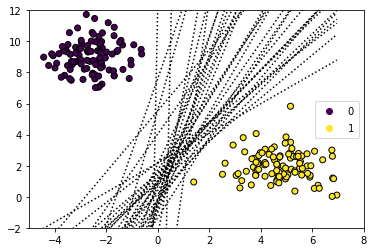

In [8]:
ax = plt.subplot(111)
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
for i in range(200, 900, 20):
    plot_decision_boundary(X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max(), blr.param_samples_[i, 1:])
ax.set_xlim(-5, 8)
ax.set_ylim(-2, 12)

ax.legend(*scatter.legend_elements())
plt.show()

It can be seen that, due to the large separation between two blobs, 
there remains considerable uncertainty when we predict the labels for points that lie at the halfway between them.

In [9]:
def plot_act_sample(clf, x, ax=None):
    a_sample = clf.predict_activation_sample(np.array([x]))[0]
    print(f"input point : {x}")
    print(f"mean of the activation : {a_sample.mean()}")
    print(f"standard deviation of the activation : {a_sample.std()}")
    if ax is None:
        ax = plt.subplot(111)
    ax.hist(a_sample, bins=np.linspace(a_sample.min(), a_sample.max(), 30), density=False)


input point : [1. 4.]
mean of the activation : -0.4833147259148027
standard deviation of the activation : 2.8211780747766046


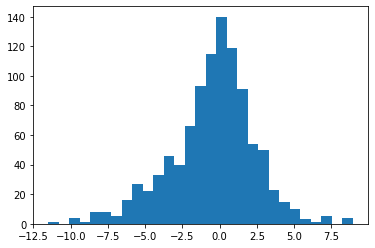

In [10]:
plot_act_sample(blr, np.array([1.0,4.0]))

Let us take a closer look at this property with another set of data. 
Here, we create blobs close to each other.

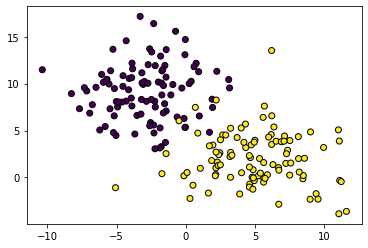

In [11]:
X2, y2 = make_blobs(n_samples=200, n_features=2, centers=2, random_state=42, cluster_std=3)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, edgecolor='k')

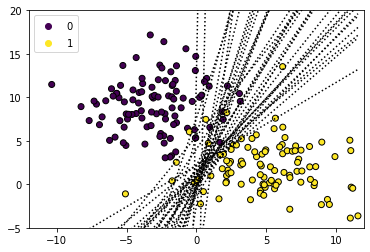

In [12]:
blr2 = BayesianLogisticRegressionMCMC()
blr2.fit(X=X2, y=y2, n_mc_sample=1000, mc_stride=20, verbose=False)

ax = plt.subplot(111)
scatter = ax.scatter(X2[:, 0], X2[:, 1], c=y2, edgecolor='k')
for i in range(200, 900, 20):
    plot_decision_boundary(X2[:,0].min(), X2[:,0].max(), X2[:,1].min(), X2[:,1].max(), blr.param_samples_[i, 1:])
ax.set_xlim(-12, 12)
ax.set_ylim(-5, 20)

ax.legend(*scatter.legend_elements())
plt.show()

It can be seen from the plot that decision boundaries are more concentrated compared with the previous case, as was expected from the fact that we no longer have large vacant space between two blobs.

This property can also be seen numerically:

input point : [1.  5.8]
mean of the activation : -0.12343181094781898
standard deviation of the activation : 0.44982394486838206


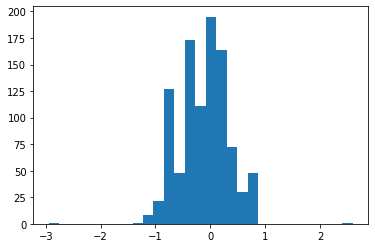

In [13]:
plot_act_sample(blr2, np.array([1.0, 5.8]))

Roughly speaking, 
* in the previous example, the classifier says "I don't have enough data to predict the label for the input point.", and
* in this example, the classifier says "I am quite sure that it is difficult to predict the label for the input point".

# 6 Experiment : breast cancer data

Next, let us apply our classifier to more realistic data.

In [14]:
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()

In [15]:
bc.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [16]:
bc.data.shape

(569, 30)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target, test_size=0.25, random_state=42)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
blr_bc = BayesianLogisticRegressionMCMC()
blr_bc.fit(X=X_train_scaled, y=y_train, n_mc_sample=1000, mc_stride=30, verbose=False, theta0=np.ones(32))

/Users/JP25564/.local/share/virtualenvs/Machine-Learning-notebooks-YWzg4cHq/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp


In [20]:
from sklearn.metrics import accuracy_score
y_pred=blr_bc.predict(scaler.transform(X_test))
accuracy_score(y_test, y_pred)

0.958041958041958

Looks not bad! Note that we have not performed any hyperparameter search (e.g. with corss validation). This is an advantage of Bayesian approach, because as the hierarchy of the model increases, the result is known to be insensitive to the fixed parameters (In the model of this notebook, the fixed parameters are $k, \lambda$.).

Another advantage of Bayesian approach is that, in contrast to maximum-likelihood approach (or any point-estimate approaches), we can obtain measure of uncertainty. This can be considerably helpful in the case where we need to take prediction uncertainty into account for decision making, such as medical application.

For example, we can make the model ouput only the predictions about which it is confident. For those the model is less confident, we may request further examination by human experts.
Here, as an ad hoc criterion, we shall use (mean activation) $\pm$ (standard deviation of activation), and let the model output only the prediction for which (mean activation) $\pm$ (standard deviation of activation) lies outside of given threshold values.

In [21]:
a_sample_bc = blr_bc.predict_activation_sample(X_test_scaled)
a_mean = a_sample_bc.mean(axis=1)
a_std = a_sample_bc.std(axis=1)
thresh = 2
confident_idx = np.where( (a_mean - a_std > thresh ) | ( a_mean + a_std < -thresh))[0]
print(f"The number of confident prediction : {len(confident_idx)}")
print(f"The number of unconfident prediction : {len(a_mean) - len(confident_idx)}")
print(f"The accuracy for confident prediction : {accuracy_score(y_test[confident_idx], y_pred[confident_idx])}")

The number of confident prediction : 133
The number of unconfident prediction : 10
The accuracy for confident prediction : 0.9774436090225563


It can be seen that we increased the accuracy by let the model output only the prediction it is confident about. 

However, note that we should pay the cost of further inspection of the samples about which the model is unconfident. In real applications, these costs should be taken into account for making decision of whether to trust the model prediction or request further inspections.